In [1]:
import os
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid
from PIL import Image
import torchvision.transforms as T
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.patches as patches


PROJECT_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")

from src.models.unet import UNet  # ← adjust if your model lives somewhere else
from src.pruning.model_inspect import (
    model_to_dataframe_with_l1,
    compute_l1_norms,
    compute_l1_stats,
    get_pruning_masks_blockwise,
)


✅ Added project root to sys.path:
   /mnt/hdd/ttoxopeus/basic_UNet


In [2]:
def get_conv_layers(model):
    conv_layers = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers[name] = module
    return conv_layers




In [3]:
# -------------------------------
# Load 3D NIfTI slice
# -------------------------------
nii_path = "/mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/imagesTr/patient001_ED_0000.nii.gz"
nii = nib.load(nii_path)
volume = nii.get_fdata()

slice_idx = volume.shape[-1] // 2
img2d = volume[:, :, slice_idx]
img2d = (img2d - np.min(img2d)) / (np.max(img2d) - np.min(img2d))

transform = T.Compose([
    T.ToTensor(),
    T.Resize((256,256)),
])
x = transform(img2d).unsqueeze(0).float()

# -------------------------------
# Load model (force to float32)
# -------------------------------
model = model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512, 512])
state = torch.load("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp47/baseline/training/final_model.pth", map_location="cpu")
model.load_state_dict(state)

for name, param in model.named_parameters():
    param.data = param.data.float()

for name, buf in model.named_buffers():
    model._buffers[name] = buf.float()

model = model.float()
model.eval()

conv_layers = get_conv_layers(model)
print("Found Conv layers:")
for layer in conv_layers:
    print(" •", layer)

# -------------------------------
# Register hooks
# -------------------------------
activations = {}
def register_hooks(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            module.register_forward_hook(
                lambda m, inp, out, n=name: activations.setdefault(n, out.detach().cpu())
            )

register_hooks(model)

# -------------------------------
# Forward pass → collect activations
# -------------------------------
_ = model(x)

block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.8,
    "encoders.1": 0.0,
    "encoders.2": 0.0,
    "encoders.3": 0.0,
    "encoders.4": 0.0,

    # --- Bottleneck ---
    "bottleneck": 0.0,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.0,
    "decoders.3": 0.0,
    "decoders.5": 0.0,
    "decoders.7": 0.0,
    "decoders.9": 0.0,
}


Found Conv layers:
 • encoders.0.net.0
 • encoders.0.net.3
 • encoders.1.net.0
 • encoders.1.net.3
 • encoders.2.net.0
 • encoders.2.net.3
 • encoders.3.net.0
 • encoders.3.net.3
 • encoders.4.net.0
 • encoders.4.net.3
 • bottleneck.net.0
 • bottleneck.net.3
 • decoders.1.net.0
 • decoders.1.net.3
 • decoders.3.net.0
 • decoders.3.net.3
 • decoders.5.net.0
 • decoders.5.net.3
 • decoders.7.net.0
 • decoders.7.net.3
 • decoders.9.net.0
 • decoders.9.net.3
 • final_conv


In [27]:
# ============================================================
# --- COMPUTE L1 NORMS ---
# ============================================================
print("📊 Computing L1 norms for all Conv layers...")
norms = compute_l1_norms(model)
l1_stats = compute_l1_stats(norms)
df = model_to_dataframe_with_l1(model, l1_stats, remove_nan_layers=True)
pd.set_option("display.max_rows", None)
print("✅ L1 statistics computed.\n")



# ============================================================
# --- GENERATE MASKS ---
# ============================================================
print("✂️ Generating pruning masks...")
masks = get_pruning_masks_blockwise(model, norms, block_ratios=block_ratios)
print("✅ Pruning masks generated.\n")

📊 Computing L1 norms for all Conv layers...
✅ L1 statistics computed.

✂️ Generating pruning masks...
🔧 Generating pruning masks...

Block encoders.0      | Layer encoders.0.net.0          | ratio=0.80 | thresh=1.7561 | kept 13/64
Block encoders.0      | Layer encoders.0.net.3          | ratio=0.80 | thresh=20.9507 | kept 13/64
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block decoders.1      | ratio=0.00 → keeping all

In [28]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

def show_feature_maps(feature_map, pruned_mask=None, num_cols=12, normalize=True):
    fmap = feature_map[0]  # [C, H, W]
    num_channels = fmap.shape[0]

    num_rows = (num_channels + num_cols - 1) // num_cols

    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(num_cols * 1.0, num_rows * 1.0),
        dpi=120
    )

    # Default mask = all True
    if pruned_mask is None:
        pruned_mask = torch.ones(num_channels, dtype=torch.bool)
    else:
        pruned_mask = pruned_mask.cpu().bool()

    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")

        if i < num_channels:
            img = fmap[i]

            if normalize:
                img = (img - img.min()) / (img.max() - img.min() + 1e-5)

            ax.imshow(img, cmap="gray", interpolation="nearest")

            # 🔢 Add channel number (top-left)
            ax.text(
                0.02, 0.02,
                str(i),
                color="white",
                fontsize=8,
                ha="left", va="top",
                transform=ax.transAxes,
                path_effects=[
                    path_effects.Stroke(linewidth=1.5, foreground="black"),
                    path_effects.Normal()
                ],
                zorder=20
            )

            # 🔴 Red border for pruned channels
            if not pruned_mask[i]:
                rect = patches.Rectangle(
                    (0, 0), 1, 1,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none',
                    transform=ax.transAxes,
                    zorder=10
                )
                ax.add_patch(rect)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


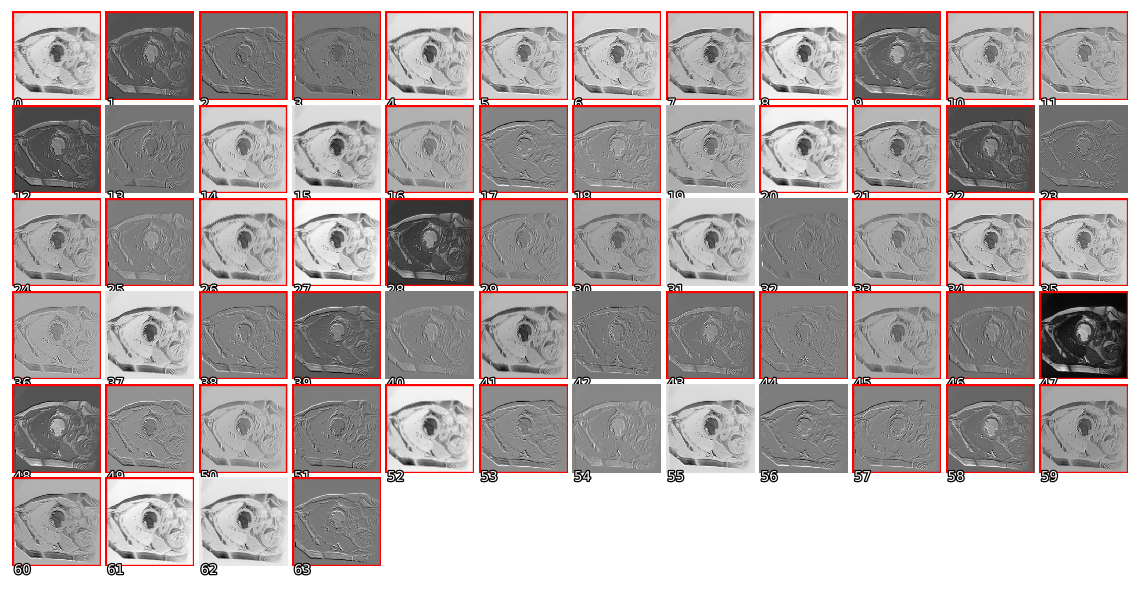

In [29]:
layer_name = "encoders.0.net.0"
show_feature_maps(activations[layer_name], pruned_mask=masks[layer_name])


In [32]:
import torch
import torch.nn as nn
import numpy as np

# -------------------------------------------------------------
# 1. Collect feature activations using forward hooks
# -------------------------------------------------------------
def get_feature_maps(model, x):
    activations = {}

    def hook(name):
        def fn(m, inp, out):
            activations[name] = out.detach().cpu()
        return fn

    handles = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            handles.append(module.register_forward_hook(hook(name)))

    model.eval()
    with torch.no_grad():
        _ = model(x)

    for h in handles:
        h.remove()

    return activations


# -------------------------------------------------------------
# 2. Compute similarity matrix for a layer
# -------------------------------------------------------------
def compute_similarity_matrix(fmap):
    fmap = fmap[0]       # [C,H,W]
    C = fmap.shape[0]

    sims = np.zeros((C, C))

    fmap_flat = fmap.reshape(C, -1).cpu().numpy()

    for i in range(C):
        for j in range(C):
            if i == j:
                sims[i, j] = 1.0
            else:
                sims[i, j] = np.corrcoef(fmap_flat[i], fmap_flat[j])[0, 1]

    return sims


# -------------------------------------------------------------
# 3. Redundancy-based mask for a layer, with PRINTING
# -------------------------------------------------------------
def redundancy_mask_from_similarity(sim_matrix, prune_ratio=0.1, threshold=0.9, layer_name=""):
    C = sim_matrix.shape[0]
    keep_mask = torch.ones(C, dtype=torch.bool)

    redundant_pairs = []

    # -------- Find redundant pairs --------
    for i in range(C):
        for j in range(i+1, C):
            if sim_matrix[i, j] > threshold:
                redundant_pairs.append((i, j))

    print(f"\n🔎 Layer: {layer_name}")
    print(f"  • Found {len(redundant_pairs)} redundant channel pairs (corr > {threshold})")

    if len(redundant_pairs) > 0:
        print("  • Redundant pairs:")
        for (i, j) in redundant_pairs:
            print(f"      - channels {i} and {j}")

    # -------- Convert to prune candidates --------
    candidates = sorted(list(set(j for (_, j) in redundant_pairs)))

    print(f"  • Unique redundant channels: {candidates}")

    # -------- Select channels to prune based on ratio --------
    max_to_prune = int(C * prune_ratio)
    to_prune = candidates[:max_to_prune]

    print(f"  • Pruning ratio: {prune_ratio} → pruning at most {max_to_prune} channels")
    print(f"  • Channels chosen for pruning: {to_prune}")

    # -------- Apply pruning --------
    for idx in to_prune:
        keep_mask[idx] = False

    kept = [i for i in range(C) if keep_mask[i]]
    removed = [i for i in range(C) if not keep_mask[i]]

    print(f"  • Kept channels:    {kept}")
    print(f"  • Removed channels: {removed}")

    return keep_mask, redundant_pairs


# -------------------------------------------------------------
# 4. MAIN FUNCTION
# -------------------------------------------------------------
def get_redundancy_pruning_masks(
    model,
    x,
    prune_ratio=0.1,
    threshold=0.9,
    target_layer=None,
):
    """
    Computes redundancy-based pruning masks using feature map correlation.

    Args:
        model: UNet (or other CNN)
        x: input tensor (1 example)
        prune_ratio: fraction of redundant channels to prune
        threshold: correlation threshold for redundancy
        target_layer: if provided, compute mask for ONLY this layer

    Returns:
        masks: dict(layer_name -> boolean mask tensor)
        activations: dict(layer_name -> feature map tensor)
        groups: dict(layer_name -> list of redundant channel pairs)
    """

    activations = get_feature_maps(model, x)
    masks = {}
    groups_dict = {}

    print("\n====================================================")
    print("🔥 REDUNDANCY-BASED PRUNING DEBUG OUTPUT")
    print("====================================================")

    # ---------------------------------------------------------
    # 🎯 If user specified a target layer
    # ---------------------------------------------------------
    if target_layer is not None:

        if target_layer not in activations:
            print(f"❌ ERROR: Layer '{target_layer}' not found.")
            print("Available layers:")
            for name in activations.keys():
                print(f"  - {name}")
            return {}, activations, {}

        print(f"\n🎯 Running ONLY for layer: {target_layer}")

        fmap = activations[target_layer]
        sim = compute_similarity_matrix(fmap)

        mask, groups = redundancy_mask_from_similarity(
            sim_matrix=sim,
            prune_ratio=prune_ratio,
            threshold=threshold,
            layer_name=target_layer,
        )

        masks[target_layer] = mask
        groups_dict[target_layer] = groups

        print("\n🎉 Completed redundancy pruning for ONE layer.\n")
        return masks, activations, groups_dict

    # ---------------------------------------------------------
    # 🔥 Otherwise: compute for ALL layers
    # ---------------------------------------------------------
    print("\n🔍 Running redundancy pruning for ALL Conv2d layers...\n")

    for layer_name, fmap in activations.items():
        sim = compute_similarity_matrix(fmap)

        mask, groups = redundancy_mask_from_similarity(
            sim_matrix=sim,
            prune_ratio=prune_ratio,
            threshold=threshold,
            layer_name=layer_name,
        )

        masks[layer_name] = mask
        groups_dict[layer_name] = groups

    print("\n🎉 Completed redundancy pruning for ALL layers.\n")
    return masks, activations, groups_dict

def plot_redundant_groups(feature_map, redundant_pairs, normalize=True):
    fmap = feature_map[0]  # [C, H, W]

    # Build connected channel groups (union-find style)
    groups = {}
    group_id = 0

    for (i, j) in redundant_pairs:
        found = False
        for gid, chans in groups.items():
            if i in chans or j in chans:
                chans.add(i)
                chans.add(j)
                found = True
                break
        if not found:
            groups[group_id] = {i, j}
            group_id += 1

    print("\n📊 Redundant Channel Groups:")
    for gid, chans in groups.items():
        print(f"  Group {gid}: {sorted(chans)}")

    # Plot each group
    for gid, chans in groups.items():
        chans = sorted(chans)
        num = len(chans)

        # Smaller per-image size (1.2×1.2 inches)
        fig, axes = plt.subplots(
            1, num,
            figsize=(num * 1.2, 1.4),   # <--- smaller images
            dpi=130,
            squeeze=False
        )
        axes = axes[0]

        for ax, ch in zip(axes, chans):
            img = fmap[ch]
            if normalize:
                img = (img - img.min()) / (img.max() - img.min() + 1e-5)

            ax.imshow(img, cmap="gray")
            ax.set_title(f"ch {ch}", fontsize=8, pad=2)
            ax.axis("off")

        # Add clean title *above* with spacing
        fig.suptitle(
            f"Redundant Group {gid}",
            fontsize=12,
            y=1.08                # <--- moves title up
        )

        plt.tight_layout(pad=0.3)   # <--- reduce padding inside figure
        plt.show()


In [35]:
masks, activations, groups = get_redundancy_pruning_masks(
    model,
    x,
    prune_ratio=1,
    threshold=0.95,
    target_layer="encoders.0.net.0"
)


🔥 REDUNDANCY-BASED PRUNING DEBUG OUTPUT

🎯 Running ONLY for layer: encoders.0.net.0

🔎 Layer: encoders.0.net.0
  • Found 61 redundant channel pairs (corr > 0.95)
  • Redundant pairs:
      - channels 0 and 8
      - channels 0 and 27
      - channels 0 and 52
      - channels 4 and 14
      - channels 4 and 52
      - channels 4 and 61
      - channels 5 and 8
      - channels 5 and 27
      - channels 5 and 55
      - channels 6 and 7
      - channels 6 and 34
      - channels 6 and 35
      - channels 7 and 34
      - channels 8 and 20
      - channels 8 and 27
      - channels 8 and 31
      - channels 8 and 37
      - channels 8 and 41
      - channels 8 and 52
      - channels 8 and 55
      - channels 8 and 62
      - channels 14 and 50
      - channels 15 and 20
      - channels 15 and 37
      - channels 15 and 52
      - channels 15 and 61
      - channels 16 and 50
      - channels 17 and 56
      - channels 20 and 27
      - channels 20 and 31
      - channels 20 and 37
   


📊 Redundant Channel Groups:
  Group 0: [0, 4, 5, 8, 15, 20, 26, 27, 31, 35, 37, 41, 45, 52, 55, 59, 61, 62]
  Group 1: [4, 14, 16, 50]
  Group 2: [6, 7, 34, 35]
  Group 3: [17, 56]
  Group 4: [21, 24, 45, 59]


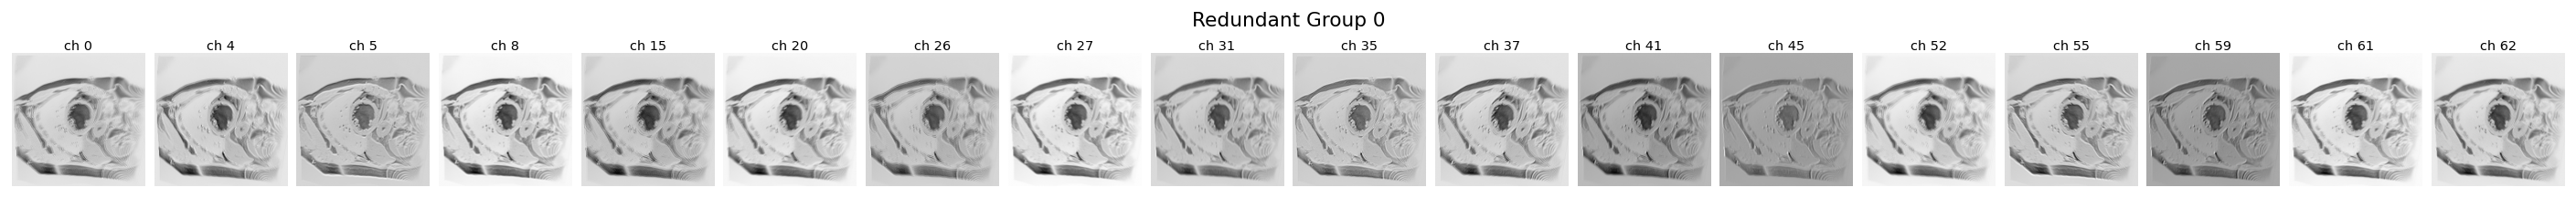

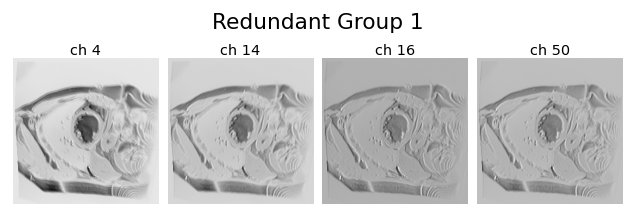

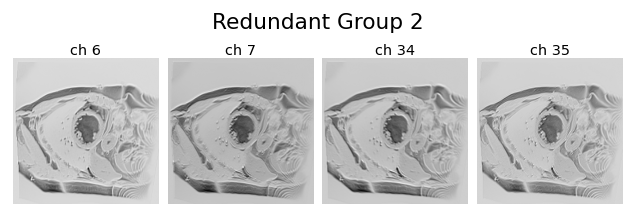

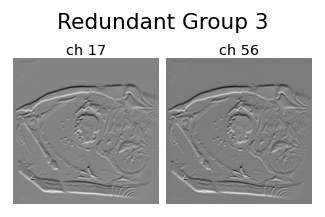

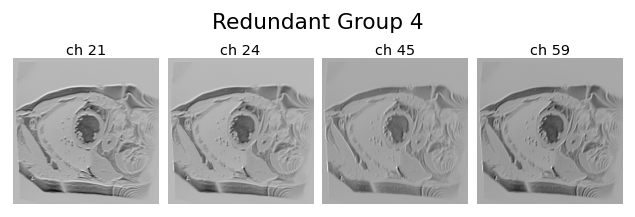

In [36]:
layer_name = "encoders.0.net.0"
feature_map = activations[layer_name]
redundant_pairs = groups[layer_name]
plot_redundant_groups(feature_map, redundant_pairs)

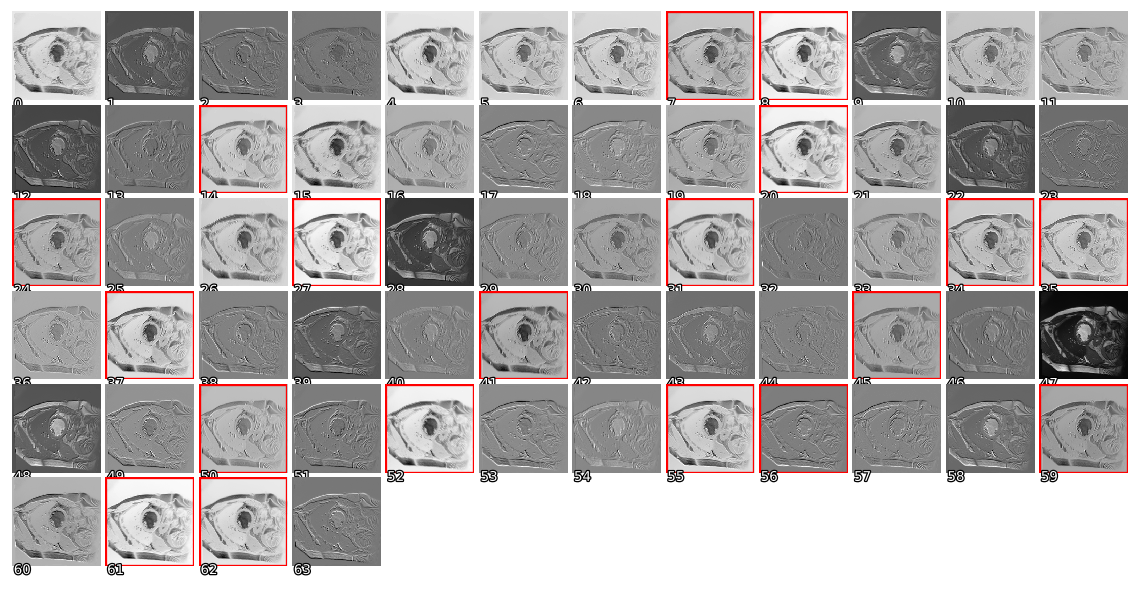

In [37]:

show_feature_maps(activations[layer_name], pruned_mask=masks[layer_name])

In [ ]:
import os
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid
from PIL import Image
import torchvision.transforms as T
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.patches as patches

PROJECT_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")

from src.models.unet import UNet
from src.pruning.rebuild import rebuild_pruned_unet
from src.pruning.redundancy import (
    get_redundancy_masks,
    get_feature_maps,
    compute_similarity_matrix,
    plot_redundancy_groups
)

import matplotlib.pyplot as plt
import numpy as np


✅ Added project root to sys.path:
   /mnt/hdd/ttoxopeus/basic_UNet


In [2]:
# -------------------------------
# Load model
# -------------------------------
model = model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512, 512])
state = torch.load("/mnt/hdd/ttoxopeus/basic_UNet/results/UNet_ACDC/exp47/baseline/training/final_model.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()
print("Model loaded")

block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.2,
    "encoders.1": 0.0,
    "encoders.2": 0.0,
    "encoders.3": 0.0,
    "encoders.4": 0.0,

    # --- Bottleneck ---
    "bottleneck": 0.0,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.0,
    "decoders.3": 0.0,
    "decoders.5": 0.0,
    "decoders.7": 0.0,
    "decoders.9": 0.0,
}

nii_path = "/mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/imagesTr/patient001_ED_0000.nii.gz"
nii = nib.load(nii_path)
volume = nii.get_fdata()

slice_idx = volume.shape[-1] // 2
img2d = volume[:, :, slice_idx]
img2d = (img2d - np.min(img2d)) / (np.max(img2d) - np.min(img2d))

transform = T.Compose([
    T.ToTensor(),
    T.Resize((256,256)),
])
x = transform(img2d).unsqueeze(0).float()



Model loaded



=== Processing Layer: encoders.0.net.0 (ratio=0.2) ===


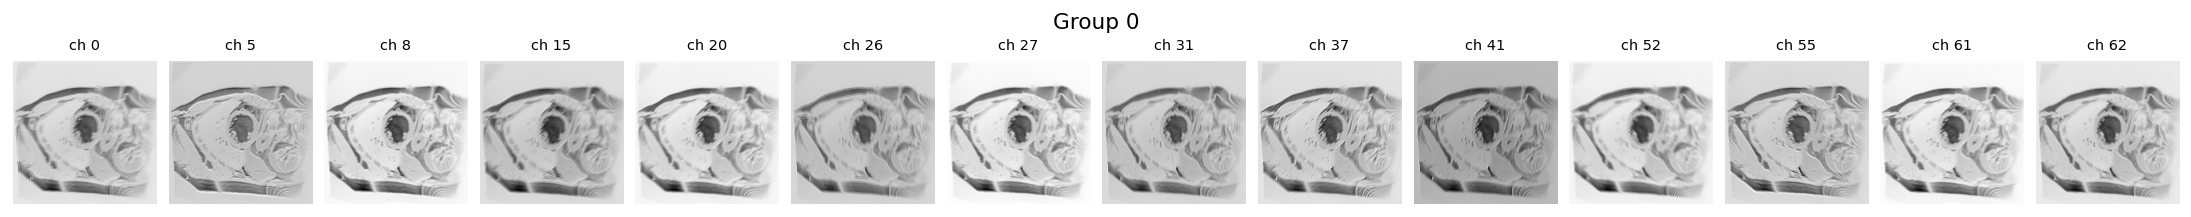

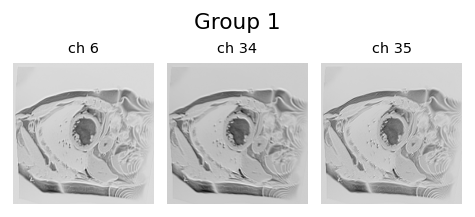

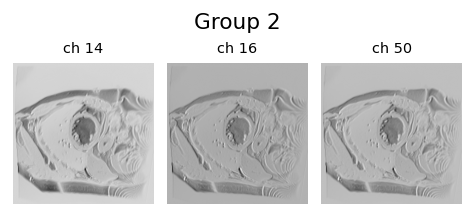

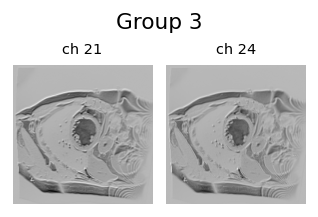

Layer encoders.0.net.0:
  - Total channels  : 64
  - Channels kept   : 52
  - Channels pruned : 12
  - Pruned percentage: 18.75%
  - Pruned indexes  : [34, 50, 27, 24, 8, 35, 52, 20, 5, 55, 16, 15]

=== Processing Layer: encoders.0.net.3 (ratio=0.2) ===


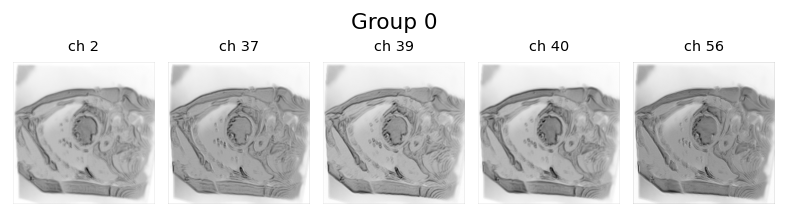

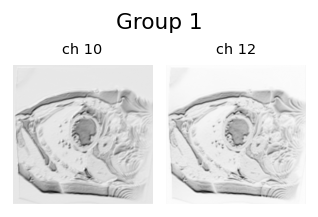

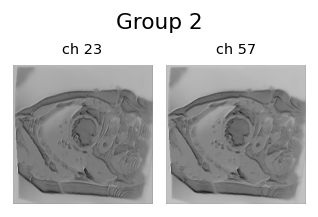

Layer encoders.0.net.3:
  - Total channels  : 64
  - Channels kept   : 58
  - Channels pruned : 6
  - Pruned percentage: 9.38%
  - Pruned indexes  : [40, 57, 39, 12, 37, 56]

================ PRUNING SUMMARY ================
Total channels before pruning: 128
Total channels after pruning:  110
Total pruned: 18 channels
Overall pruning percentage: 14.06%


===== GENERATED MASKS =====
encoders.0.net.0.weight torch.Size([64]) 52 / 64
encoders.0.net.0.bias torch.Size([64]) 52 / 64
encoders.0.net.3.weight torch.Size([64]) 58 / 64
encoders.0.net.3.bias torch.Size([64]) 58 / 64


In [3]:
masks = get_redundancy_masks(
    model=model,
    x=x,
    block_ratios=block_ratios,
    threshold=0.96
)

print("\n===== GENERATED MASKS =====")
for k, v in masks.items():
    print(k, v.shape, v.sum().item(), "/", len(v))


In [ ]:
pruned_model = rebuild_pruned_unet(model, masks)